<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - RadCLss Verification

## Overview

The Extracted Radar Columns and In-Situ Sensors (RadClss) Value-Added Product (VAP) is
a dataset containing in-situ ground observations matched to CSAPR-2 radar columns above ARM Mobile Facility (AMF-3) supplemental sites of interest. 

RadCLss is intended to provide a dataset for algorthim development and validation of precipitation retrievals.

This notebook will allow for verification of the interpolation schemes within RadCLss through comparison with the input datastreams

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/README.html) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask
import cartopy.crs as ccrs

from math import atan2 as atan2
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES
from scipy.stats import linregress

import act
import pyart

dask.config.set({'logging.distributed': 'error'})


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
ds_rad = xr.open_dataset("/home/obrienj/git-dev/bnf-radar-examples/notebooks/data/radclss/bnf-csapr2-radclss.c2.20250305.000000.nc")

In [3]:
ds_rad

<xarray.Dataset> Size: 3MB
Dimensions:                                                (time: 142,
                                                            station: 6,
                                                            height: 32)
Coordinates:
  * time                                                   (time) datetime64[ns] 1kB ...
  * station                                                (station) <U3 72B ...
  * height                                                 (height) int64 256B ...
Data variables: (12/67)
    base_time                                              datetime64[ns] 8B ...
    time_offset                                            (time) datetime64[ns] 1kB ...
    gate_time                                              (time, station) datetime64[ns] 7kB ...
    attenuation_corrected_differential_reflectivity        (time, height, station) float64 218kB ...
    attenuation_corrected_differential_reflectivity_lag_1  (time, height, station) float64 218kB ...
    attenuation_corrected_reflectivity_h                   (time, height, station) float64 218kB ...
    ...                                                     ...
    wxt_temp_mean                                          (time, station) float64 7kB ...
    wxt_precip_rate_mean                                   (time, station) float64 7kB ...
    wxt_cumul_precip                                       (time, station) float64 7kB ...
    lat                                                    (station) float64 48B ...
    lon                                                    (station) float64 48B ...
    alt                                                    (station) int64 48B ...
Attributes: (12/23)
    Conventions:           CF/Radial instrument_parameters ARM-1.3
    command_line:          python bnf_radclss.py --serial True --array True
    process_version:       
    dod_version:           csapr2radclss-c2-1.28
    input_datastreams:     bnfcsapr2cmacS3.c1
    site_id:               bnf
    ...                    ...
    vap_name:              
    known_issues:          False phidp jumps in insect regions. Still uses ol...
    field_names:           base_time, time_offset, time, height, station, gat...
    source:                Atmospheric Radiation Measurement (ARM) program C-...
    history:               created by user jrobrien on machine cumulus.ccs.or...
    location_descrption:   Southeast U.S. in Bankhead National Forest (BNF), ...

In [4]:
ds_met = act.io.read_arm_netcdf("/nfs/gce/globalscratch/obrienj/bnf-insitu/bnfmetM1.b1/bnfmetM1.b1.20250305.000000.cdf", cleanup_qc=True)
ds_pluv = act.io.read_arm_netcdf("/nfs/gce/globalscratch/obrienj/bnf-insitu/bnfwbpluvio2M1.a1/bnfwbpluvio2M1.a1.20250305.000000.nc", cleanup_qc=True)
ds_sonde = act.io.read_arm_netcdf("/nfs/gce/globalscratch/obrienj/bnf-insitu/bnfsondewnpnM1.b1/bnfsondewnpnM1.b1.20250305.172900.cdf", cleanup_qc=True)
ds_ld = act.io.read_arm_netcdf("/nfs/gce/globalscratch/obrienj/bnf-insitu/bnfldquantsM1.c1/bnfldquantsM1.c1.20250305.000000.nc", cleanup_qc=True)

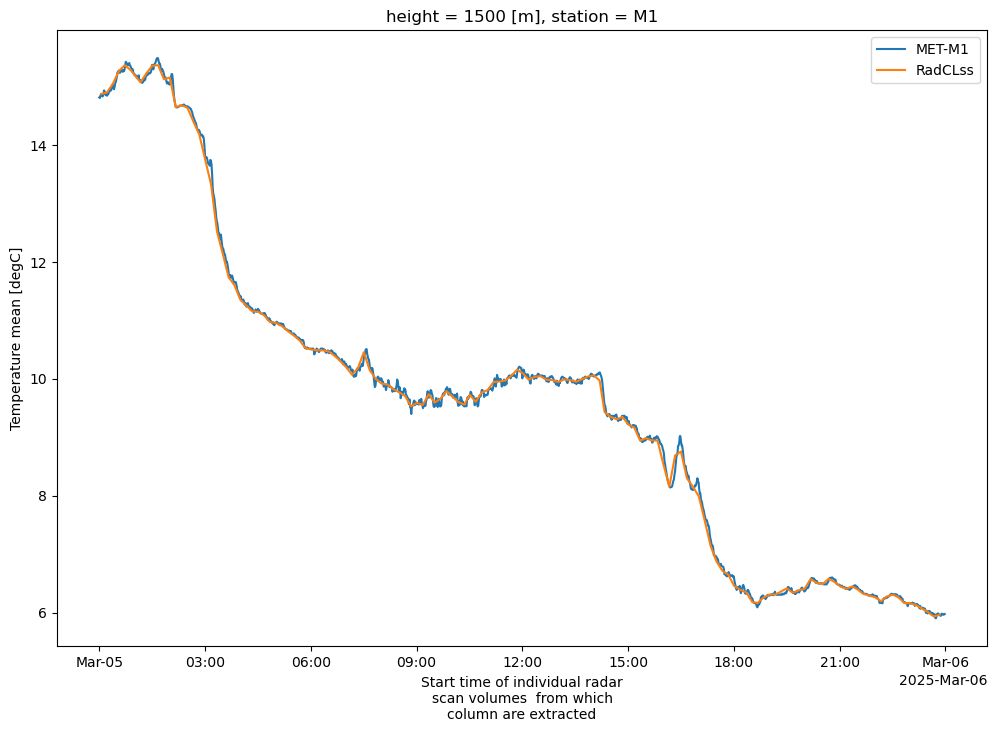

In [5]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_met.temp_mean.plot(ax=axs, label="MET-M1")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").temp_mean.plot(ax=axs, label="RadCLss")

axs.legend(loc='upper right')

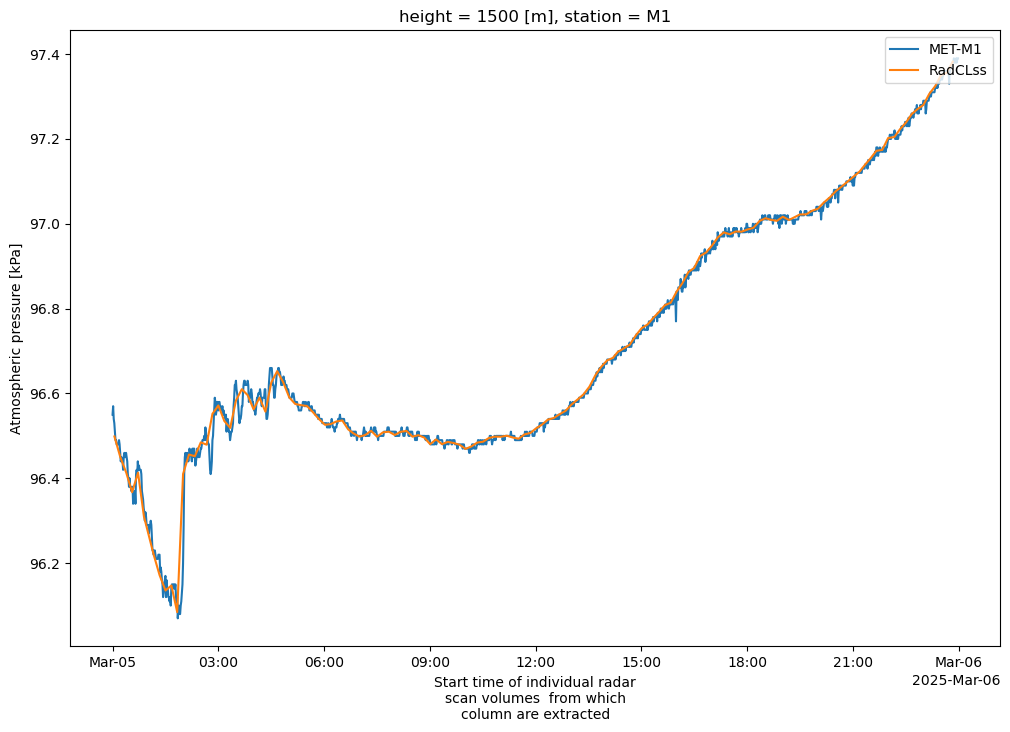

In [6]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_met.atmos_pressure.plot(ax=axs, label="MET-M1")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").atmos_pressure.plot(ax=axs, label="RadCLss")

axs.legend(loc='upper right')

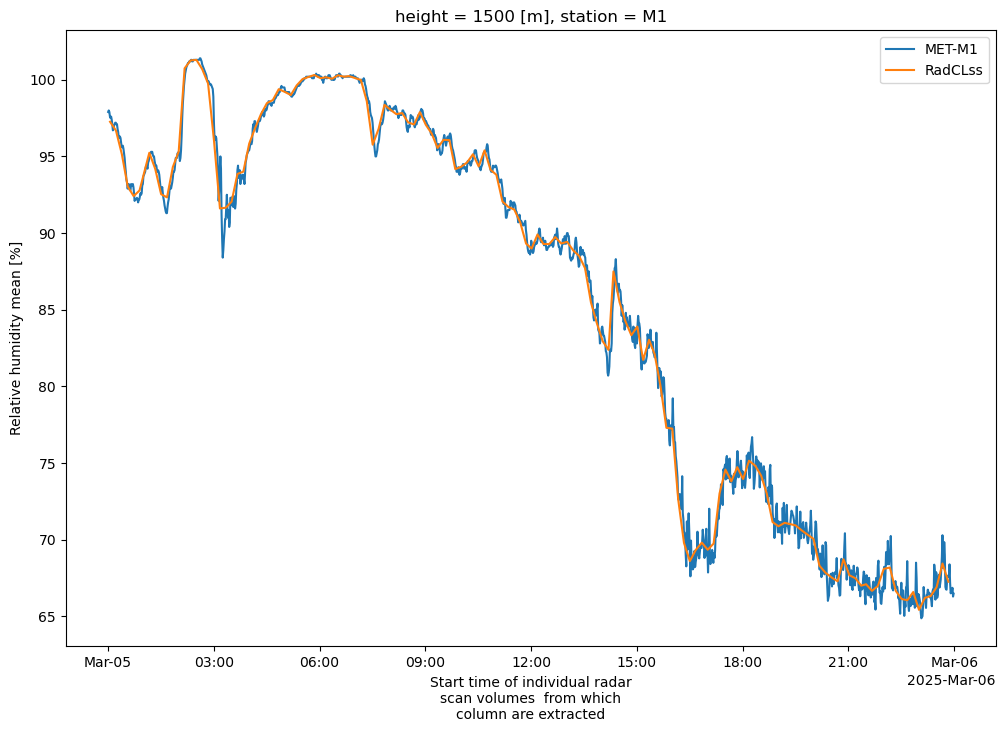

In [7]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_met.rh_mean.plot(ax=axs, label="MET-M1")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").rh_mean.plot(ax=axs, label="RadCLss")

axs.legend(loc='upper right')

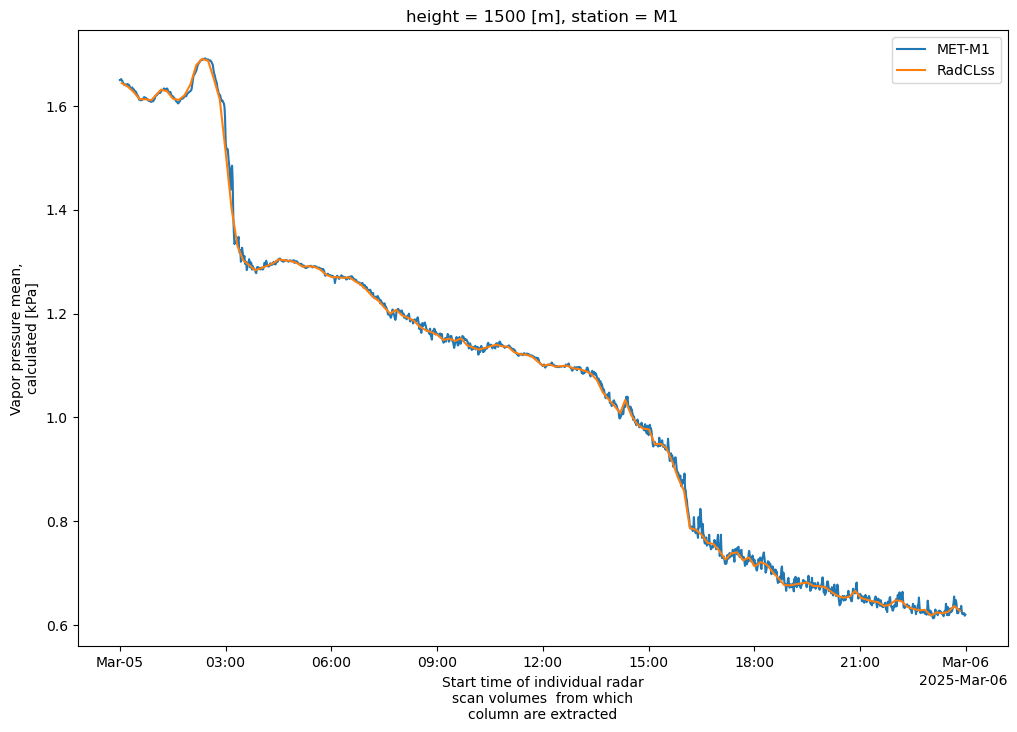

In [8]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_met.vapor_pressure_mean.plot(ax=axs, label="MET-M1")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").vapor_pressure_mean.plot(ax=axs, label="RadCLss")

axs.legend(loc='upper right')

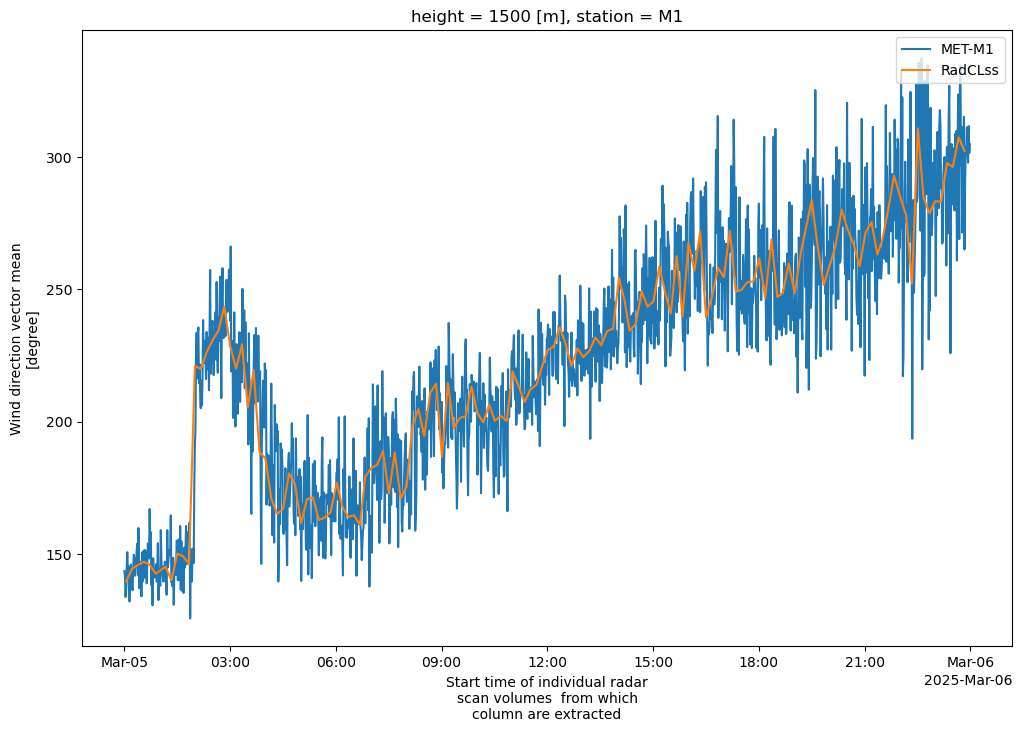

In [9]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_met.wdir_vec_mean.plot(ax=axs, label="MET-M1")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").wdir_vec_mean.plot(ax=axs, label="RadCLss")

axs.legend(loc='upper right')

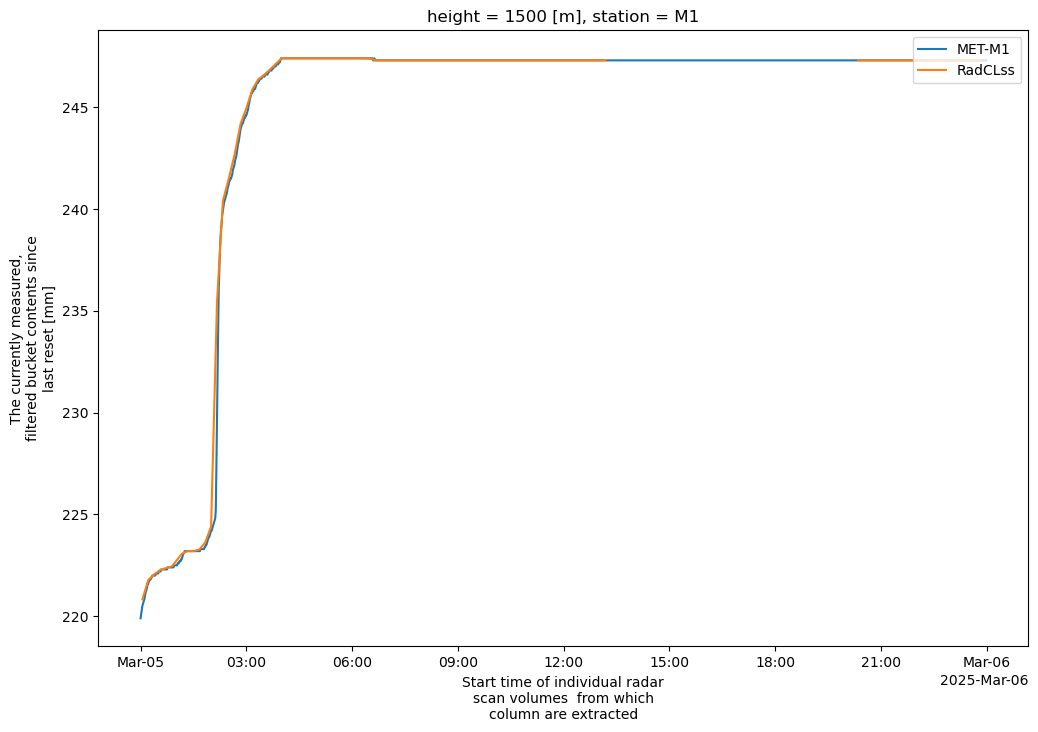

In [10]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_pluv.bucket_nrt.plot(ax=axs, label="MET-M1")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").bucket_nrt.plot(ax=axs, label="RadCLss")

axs.legend(loc='upper right')

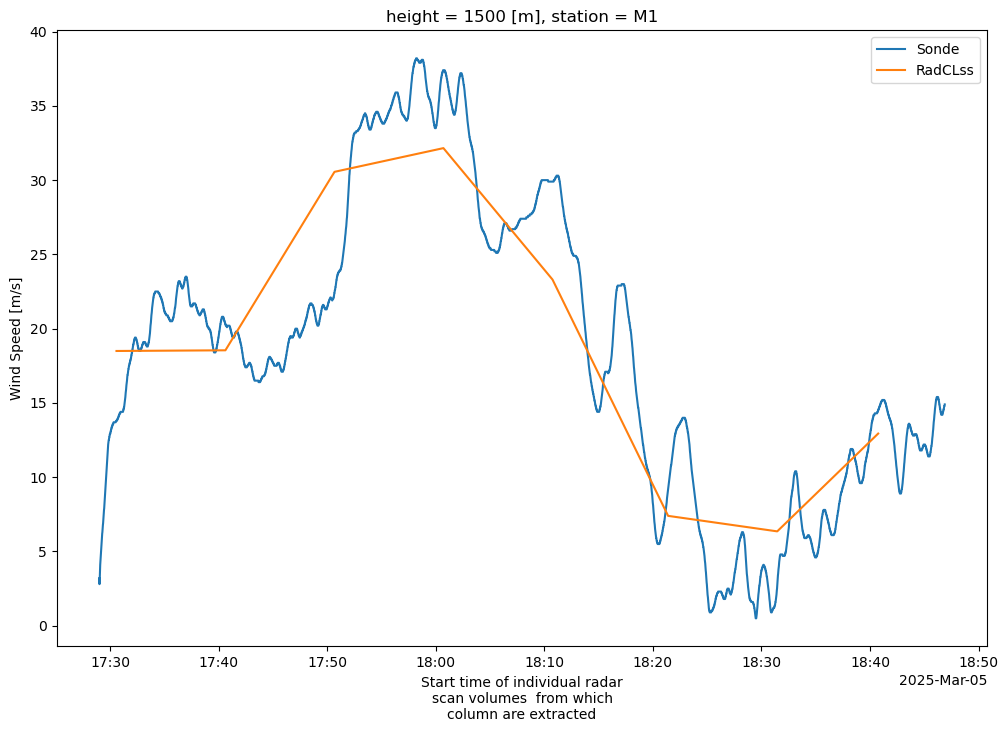

In [11]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_sonde.wspd.plot(ax=axs, label="Sonde")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").sonde_wspd.plot(ax=axs, label="RadCLss")
axs.legend(loc="upper right")

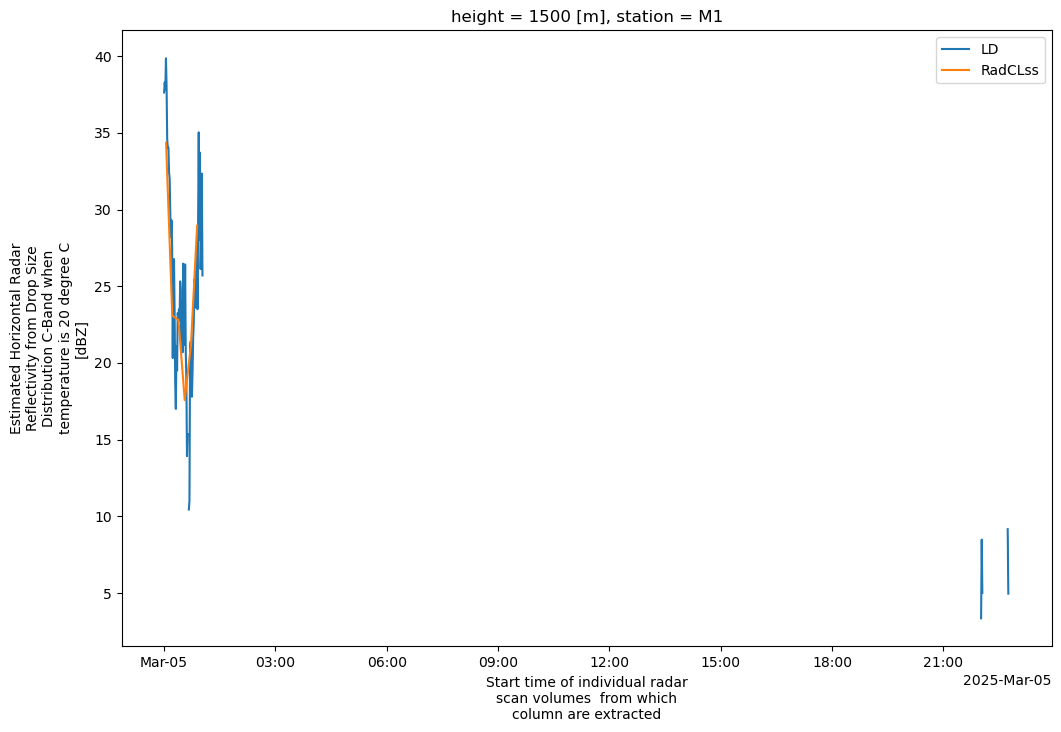

In [12]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_ld.reflectivity_factor_cband20c.plot(ax=axs, label="LD")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").ldquants_reflectivity_factor_cband20c.plot(ax=axs, label="RadCLss")
axs.legend(loc="upper right")

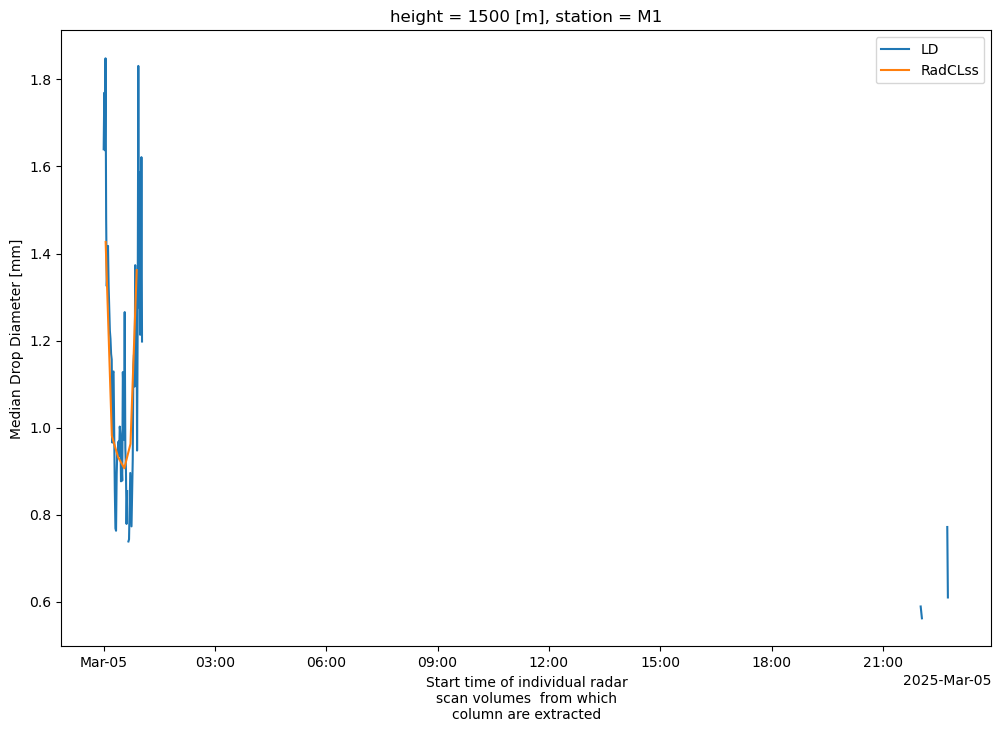

In [13]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_ld.med_diameter.plot(ax=axs, label="LD")
ds_rad.sel(station="M1").sel(height=1600, method="nearest").ldquants_med_diameter.plot(ax=axs, label="RadCLss")
axs.legend(loc="upper right")

## Interactive Visualization - Panel + hvplot

### CSAPR-2 / CMAC Fields

In [14]:
[var for var, dim in ds_rad.items() if "height" in dim.dims]

['attenuation_corrected_differential_reflectivity',
 'attenuation_corrected_differential_reflectivity_lag_1',
 'attenuation_corrected_reflectivity_h',
 'copol_correlation_coeff',
 'corrected_velocity',
 'corrected_differential_phase',
 'filtered_corrected_differential_phase',
 'corrected_specific_diff_phase',
 'filtered_corrected_specific_diff_phase',
 'corrected_differential_reflectivity',
 'corrected_reflectivity',
 'rain_rate_A',
 'rain_rate_Z',
 'rain_rate_Kdp']

In [16]:
import hvplot.xarray  # registers .hvplot
import panel as pn

pn.extension()

# --- Widgets ---

# separate out the CSAPR-2 / CMAC variables by checking for the height dimension
cmac_var = [var for var, dim in ds_rad.items() if "height" in dim.dims]

# --- Widgets ---

# variable selection
var_select = pn.widgets.Select(
    name='Variable',
    options=cmac_var,
    value='attenuation_corrected_reflectivity_h'
)
# station selection
station_select = pn.widgets.Select(
    name='Station',
    options=list(ds_rad['station'].values),
    value=str(ds_rad['station'].values[0])
)

# --- Plotting function ---

def make_plot(var_name, station, kind):
    da = ds_rad[var_name]

    # Ensure we are working with a 2D slice for 3D variables (time, height, station)
    if 'station' in da.dims:
        da = da.sel(station=station)

    if {'time', 'height'} <= set(da.dims):
        return da.hvplot.quadmesh(
            x='time',
            y='height',
            colorbar=True,
            cmap="ChaseSpectral",  
            width=800,
            height=400,
            title=f"{var_name} (station={station})"
        )
    else:
        # Fallback: time series at this station (height-aggregated or first height)
        if 'height' in da.dims:
            da = da.isel(height=1500)  # or da.mean('height')

        return da.hvplot(
            x='time',
            kind='line',
            width=800,
            height=400,
            title=f"{var_name} (station={station})"
        )

# Bind widgets to function
interactive_plot = pn.bind(
    make_plot,
    var_name=var_select,
    station=station_select,
    kind="quadmesh",
)

dashboard = pn.Column(
    pn.Row(var_select, station_select),
    interactive_plot,
)

dashboard


BokehModel(combine_events=True, render_bundle={'docs_json': {'a87ec0a2-dbd7-4a48-a9de-9676feb0c7e1': {'version…

## MET (RadCLss version)

In [17]:
import hvplot.xarray  # noqa: F401, needed to register .hvplot
import panel as pn
import numpy as np

pn.extension()

met_var = []
for var in ds_rad:
    if hasattr(ds_rad[var], "source"):
        if ds_rad[var].attrs['source'] == "bnfmetM1.b1":
            met_var.append(var)

# ---- 2. Widgets ----

var_select = pn.widgets.Select(
    name='Variable',
    options=met_var,
    value=met_var[0],
)

kind_select = pn.widgets.Select(
    name='Plot Kind',
    options=['line', 'scatter'],
    value='line',
)

height_slider = pn.widgets.DiscreteSlider(
    name='Height',
    options=list(ds_rad['height'].values),
    value=float(np.array(ds_rad['height'].values)[0]),
    visible=False,  # start hidden; shown only for 3D vars
)

# ---- 3. Plotting function bound to widget values ----

def make_plot(var_name, kind, height_level):
    da = ds_rad[var_name]

    # If the selected variable is 3D (time, height, station), slice at the chosen height
    if 'height' in da.dims:
        # Show the slider if this variable has height
        height_slider.visible = True

        # Slice at the nearest height level
        da2 = da.sel(height=height_level, method='nearest')

        title = f"{var_name} at height={float(da2['height'].values):.1f}"
    else:
        # Hide the slider for 2D fields
        height_slider.visible = False
        da2 = da
        title = var_name

    # We assume dims include 'time' and 'station'
    return da2.hvplot(
        x='time',
        kind=kind,
        by='station',   # each station gets its own line/color
        frame_height=450,
        width=750,
        title=title,
        legend="bottom",
        legend_opts={"label_text_font_size": "8pt"}
    )


# Bind function to widgets; Panel will re-run when any widget value changes
interactive_plot = pn.bind(
    make_plot,
    var_name=var_select,
    kind=kind_select,
    height_level=height_slider,
)

# ---- 4. Layout ----

dashboard = pn.Column(
    pn.Row(var_select, kind_select, height_slider),
    interactive_plot,
)

dashboard  # in notebook, or `panel serve` if running as app


BokehModel(combine_events=True, render_bundle={'docs_json': {'147af14a-4201-458a-bfe5-b1eaf207ba59': {'version…

## MET - RadCLss Comparison